In [5]:
import pandas as pd
import configparser
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%aimport helper
%aimport import_dfs

from IPython.core.display import display, HTML
from matplotlib.pyplot import figure
from import_dfs import Datenbank
import helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
db = Datenbank()

['anpassungen_rf', 'besetzungsgrade', 'bevoelkerungs_und_emissiondaten', 'bevoelkerungsverteilung', 'gemis_data', 'informationen_rad', 'rf_gv_basis', 'rf_gv_pod', 'rf_gv_strecken', 'rf_pv_basis', 'rf_pv_pod', 'rf_pv_strecken', 'spezifischer_verbrauch', 'staedte', 'technologiedaten', 'verbesserungsfaktoren', 'verkehrsleistung_miv_(omm)']


In [30]:
rf_pv_basis = db.rf_pv_basis.copy()
rf_pv_routes = db.rf_pv_strecken.copy()
tech_data = db.technologiedaten.copy()

def calc_airspeed(rf_pv_basis, rf_pv_routes):
    df_airspeed_calc = rf_pv_basis.join(rf_pv_routes, on='name_verbindung', rsuffix='_x').drop([
        'stadt_id_start',
        'stadt_start',
        'stadt_ende',
        'stadt_id_ende',
        'startpunkt',
        'endpunkt'
        ], axis = 1)
    df_airspeed_calc = df_airspeed_calc.assign(av_speed=(df_airspeed_calc['luftlinie']/df_airspeed_calc['transferzeit'])*0.06)
    df_airspeed_calc = df_airspeed_calc.drop(columns='strecken_typ_x')
    return df_airspeed_calc

df_airspeed = calc_airspeed(rf_pv_basis, rf_pv_routes)
df.head()

,strecken_typ,name_verbindung,transferzeit,wartezeit,fahrtzeit,length,bike_sharing,e_bike,taxi,zu_fuss,fahrrad,flugzeug,miv,luftlinie,av_speed,oev,main_mode,num_modes,only_mode
index,,,,,,,,,,,,,,,,,,,
0.0,UK,1.0,30.0000,0,30,2500,0.0,0.0,0.0,2500.0,0.0,0.0,0.0,2000.0,4.000000,0.0,zu_fuss,1,True
1.0,UK,1.0,8.0000,0,8,2600,0.0,0.0,0.0,0.0,2600.0,0.0,0.0,2000.0,15.000000,0.0,fahrrad,1,True
2.0,UK,1.0,16.0000,0,16,3600,0.0,0.0,0.0,400.0,0.0,0.0,3200.0,2000.0,7.500000,0.0,miv,2,False
3.0,UK,1.0,19.0000,1,18,3790,0.0,0.0,0.0,500.0,0.0,0.0,0.0,2000.0,6.315789,3290.0,oev,2,False
4.0,UK,1.0,7.0909,0,7,2600,0.0,2600.0,0.0,0.0,0.0,0.0,0.0,2000.0,16.923099,0.0,e_bike,1,True


In [39]:
df = df_airspeed.copy() 

unique_vals = helper.find_unique_modes(tech_data)
unique_modes = [x for x in unique_vals if x in df.columns]

oev_list = ['bus','tram', 'u_bahn','zug_fernverkehr', 'zug_nahverkehr']

df.loc[:, 'oev'] = df.reindex(oev_list, axis='columns').sum(axis=1)

df = df.drop(columns=oev_list)

unique_modes_wout_oev = [x for x in unique_modes if x in df.columns] + ['oev']

df.loc[:, 'main_mode'] = df.loc[:, unique_modes_wout_oev].idxmax(axis=1)  # find mode with highest length percentage
df.loc[:, 'num_modes'] = (df.loc[:, unique_modes_wout_oev] > 0).sum(axis=1)   # find number of modes in row
df.loc[:, 'only_mode'] = np.where(df['num_modes'] == 1, True, False)  # if num modes == 1 -> only_mode = True

df.loc[:, ['wartezeit', 'fahrtzeit', 'length']] = df.loc[:, ['wartezeit', 'fahrtzeit', 'length']].round(0).astype(int)

df

,strecken_typ,name_verbindung,transferzeit,wartezeit,fahrtzeit,length,bike_sharing,e_bike,taxi,zu_fuss,fahrrad,flugzeug,miv,luftlinie,av_speed,oev,main_mode,num_modes,only_mode
index,,,,,,,,,,,,,,,,,,,
0.0,UK,1.0,30.0000,0,30,2500,0.0,0.0,0.0,2500.0,0.0,0.0,0.0,2000.0,4.000000,0.0,zu_fuss,1,True
1.0,UK,1.0,8.0000,0,8,2600,0.0,0.0,0.0,0.0,2600.0,0.0,0.0,2000.0,15.000000,0.0,fahrrad,1,True
2.0,UK,1.0,16.0000,0,16,3600,0.0,0.0,0.0,400.0,0.0,0.0,3200.0,2000.0,7.500000,0.0,miv,2,False
3.0,UK,1.0,19.0000,1,18,3790,0.0,0.0,0.0,500.0,0.0,0.0,0.0,2000.0,6.315789,3290.0,oev,2,False
4.0,UK,1.0,7.0909,0,7,2600,0.0,2600.0,0.0,0.0,0.0,0.0,0.0,2000.0,16.923099,0.0,e_bike,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216.0,L,44.0,665.0000,199,466,721340,0.0,0.0,0.0,2790.0,0.0,0.0,0.0,421270.0,38.009323,718550.0,oev,2,False
217.0,L,44.0,260.0000,90,170,549060,0.0,0.0,39300.0,1500.0,0.0,460760.0,47500.0,421270.0,97.216154,0.0,flugzeug,4,False
218.0,L,44.0,297.0000,109,188,540100,0.0,0.0,39300.0,1200.0,0.0,460760.0,0.0,421270.0,85.105051,38840.0,flugzeug,4,False


# Darstellung der Luftliniengeschwindigkeiten

,strecken_typ,name_verbindung,transferzeit,wartezeit,fahrtzeit,length,bike_sharing,e_bike,taxi,zu_fuss,fahrrad,flugzeug,miv,luftlinie,av_speed,oev,main_mode,num_modes,only_mode
index,,,,,,,,,,,,,,,,,,,
0.0,UK,1.0,30.0000,0,30,2500,0.0,0.0,0.0,2500.0,0.0,0.0,0.0,2000.0,4.000000,0.0,zu_fuss,1,True
1.0,UK,1.0,8.0000,0,8,2600,0.0,0.0,0.0,0.0,2600.0,0.0,0.0,2000.0,15.000000,0.0,fahrrad,1,True
2.0,UK,1.0,16.0000,0,16,3600,0.0,0.0,0.0,400.0,0.0,0.0,3200.0,2000.0,7.500000,0.0,miv,2,False
3.0,UK,1.0,19.0000,1,18,3790,0.0,0.0,0.0,500.0,0.0,0.0,0.0,2000.0,6.315789,3290.0,oev,2,False
4.0,UK,1.0,7.0909,0,7,2600,0.0,2600.0,0.0,0.0,0.0,0.0,0.0,2000.0,16.923099,0.0,e_bike,1,True


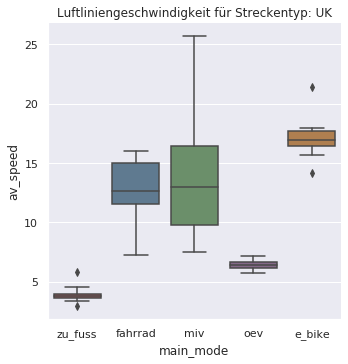

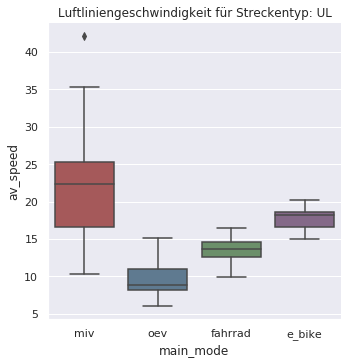

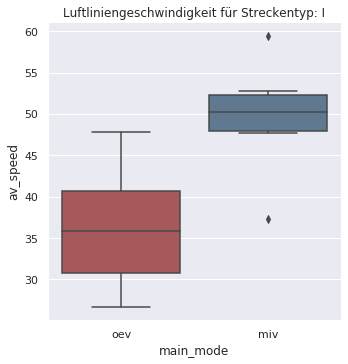

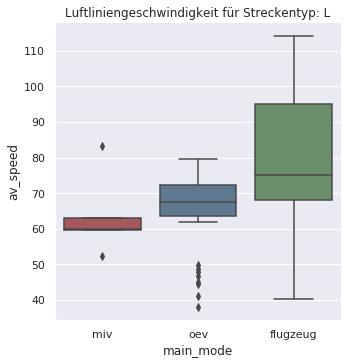

In [41]:
sns.set()
sns.set_palette("Set1", n_colors=8, desat=.5)

display(HTML(df.head().to_html()))

grouped = df.groupby("strecken_typ")

for n in ['UK', 'UL', 'I', 'L']:
    grp = grouped.get_group(n)
    sns.catplot(x="main_mode",y="av_speed", kind="box", data=grp)
    plt.title(f'Luftliniengeschwindigkeit für Streckentyp: {n}', size=12)
    
plt.show()

# Darstellung der durchschnittlichen Streckenlängen

,Streckenlänge,Einheit
UK,2.72,km
UL,15.63,km
I,183.47,km
L,554.83,km


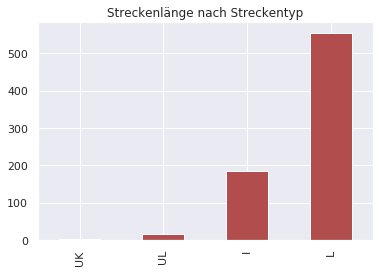

In [42]:
grouped = df.groupby("strecken_typ")

av_route_length = dict()

for n, group in grouped:
    av_route_length[n] = [round(group.loc[:,"length"].mean()/1000, 2) ,'km']
    
df_route_length = pd.DataFrame.from_dict(av_route_length, orient="index" ,columns=["Streckenlänge", 'Einheit']).sort_values(['Streckenlänge'])
df_route_length.plot(kind="bar", title='Streckenlänge nach Streckentyp', legend=False)

display(HTML(df_route_length.to_html()))
plt.show()